### FIN 3080 homework 1 for 122090436

### DATA preprocessing


first step: read the data stored in excel using pandas

In [1]:
# import relevant module to analyze the data
import pandas as pd
# data_1 concludes basic information of all stocks in A shares
data_1 = pd.read_excel("./TRD_Co.xlsx")
# data 2 includes monthly stock prices, stock returns, market value of 
# tradable shares in all A shares market
data_2 = pd.read_excel("./TRD_Mnth.xlsx")
# data_3 includes basic info regarding total assets, total liabilities, R&D expense
data_3 = pd.read_excel("./FS_Combas.xlsx")
# drop the header of the data
data_1 = data_1.drop(data_1.index[:2])
data_2 = data_2.drop(data_2.index[:2])
data_3 = data_3.drop(data_3.index[:2])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [2]:
data_3.head()

,FS_Combas.Stkcd,FS_Combas.Accper,FS_Combas.Typrep,FS_Combas.A001000000,FS_Combas.A002000000,FS_Combas.ShortName_EN,FS_Comins.B001216000,FI_T5.F050104C,FI_T5.F050504C,FI_T9.F090101C,FI_T9.F091001A
2,000001,2023-09-30,A,5516388000000,5050528000000,PAYH,NaN,0.011228,0.108819,2.498815,24.005978
3,000001,2023-09-30,B,5511916000000,5050539000000,PAYH,NaN,0.010726,0.104803,2.388179,23.774967
4,000001,2023-06-30,A,5500524000000,5048451000000,PAYH,NaN,0.011575,0.112975,2.515459,23.295527
5,000001,2023-06-30,B,5496231000000,5048493000000,PAYH,NaN,0.011062,0.108791,2.40405,23.072143
6,000001,2023-03-31,A,5455897000000,5009152000000,PAYH,NaN,0.011242,0.110838,2.435742,23.020973


second step: preclearing the data in their corresponding dataframes

In [3]:
# change of name of columns to enhance readabilty
data_1.columns = ["stock_code", "stock_acronym", "date_listed", "establishment_date", "market_type"]

# change the type of the data
data_1["date_listed"] = pd.to_datetime(data_1["date_listed"])
data_1["establishment_date"] = pd.to_datetime(data_1["establishment_date"])
data_1 = data_1.astype({"market_type": int})
data_1 = data_1.reset_index(drop=True)

data_2.columns = ["stock_code", "trading_month", "monthly_closing_price",
                  "tradable_market_value", "total_market_value", "monthly_return"]
data_2["trading_month"] = pd.to_datetime(data_2["trading_month"])
data_2 = data_2.astype({"monthly_closing_price": float, "tradable_market_value": float,
                        "total_market_value": float, "monthly_return": float})
# adjust the unit of the data
data_2["tradable_market_value"] = data_2["tradable_market_value"] * 1000
data_2["total_market_value"] = data_2["total_market_value"] * 1000
data_2.dropna(inplace=True)
data_2 = data_2.reset_index(drop=True)

data_3.columns = ["stock_code", "ending_date", "statement_type", "total_assets",
                  "total_liabilities", "stock_short_name", "rd_expense", "ROA", "ROE", "EPS", "net_asset_per_share"]
data_3["ending_date"] = pd.to_datetime(data_3["ending_date"])
data_3 = data_3.astype({"total_assets": float, "total_liabilities": float,
                        "rd_expense": float, "ROA": float, "ROE" : float,
                        "EPS":float, "net_asset_per_share": float})
data_3 = data_3.reset_index(drop=True)
data_3 = data_3.groupby('stock_code').apply(lambda x: x.sort_values('ending_date'))
data_3 = data_3.reset_index(drop=True)
# select all "A" financial report after the year 2000
musk = (data_3["ending_date"] >= "1999-12-31") & (data_3["statement_type"] == "A")
data_3 = data_3[musk]
data_3 = data_3.reset_index(drop=True)

# fill the NaN data which is caused by delay of annoucement or accounting factors
data_3["ROA"].fillna(method="ffill", inplace=True)
data_3["ROE"].fillna(method="ffill", inplace=True)
data_3["EPS"].fillna(method="ffill", inplace=True)
data_3["rd_expense"].fillna(0, inplace=True)
data_3.dropna(inplace=True)
data_3 = data_3.reset_index(drop=True)


third step: merge three dataframe into a final_data set for simplicity and analysing monthly data

In [4]:
# Get the current time in datetime64[ns] format, it's more convenient to analyze company ages in data_1
current_time = pd.Timestamp.now()
data_1["quarterly_firm_ages(by_year)"] = current_time - data_1["establishment_date"]
# convert ages to years
data_1["quarterly_firm_ages(by_year)"] = pd.to_timedelta(data_1["quarterly_firm_ages(by_year)"], unit='D') / pd.Timedelta(days=365.25)

In [5]:
# first merge the dataframe storing stocks' monthly price with another dataframe storing basic info of pertinant stock
demo_merge = data_2.merge(data_1, on="stock_code", how="inner")

# define a adding lagged variable funcition to faciliate the merging of the dataframe
def add_lagged(trading_time):
    year = trading_time.year
    month = trading_time.month
    day = trading_time.day
    if month in [1, 2, 3]:
        return f"{year-1}-12-31"
    if month in [4, 5, 6]:
        return f"{year}-03-31"
    if month in [7, 8, 9]:
        return f"{year}-06-30"
    if month in [10, 11, 12]:
        return f"{year}-09-30"
    
demo_merge["ending_date"] = demo_merge["trading_month"].apply(add_lagged)
demo_merge["ending_date"] = pd.to_datetime(demo_merge["ending_date"])
final_data = pd.merge(demo_merge, data_3, on=["stock_code", "ending_date"], how="inner")
# here is the brief introduction of the data
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659669 entries, 0 to 659668
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   stock_code                    659669 non-null  object        
 1   trading_month                 659669 non-null  datetime64[ns]
 2   monthly_closing_price         659669 non-null  float64       
 3   tradable_market_value         659669 non-null  float64       
 4   total_market_value            659669 non-null  float64       
 5   monthly_return                659669 non-null  float64       
 6   stock_acronym                 659669 non-null  object        
 7   date_listed                   659669 non-null  datetime64[ns]
 8   establishment_date            659669 non-null  datetime64[ns]
 9   market_type                   659669 non-null  int64         
 10  quarterly_firm_ages(by_year)  659669 non-null  float64       
 11  ending_date  

### ---------------Time to solve the homework question!-----------------------

In [6]:
# question 1 (a)
final_data["monthly_PE_ratio"] = final_data["monthly_closing_price"] / (final_data["EPS"])
final_data["monthly_PB_ratio"] = final_data["monthly_closing_price"] / (final_data["net_asset_per_share"])
final_data["quarterly_R&D_expense_by_total_asset"] = final_data["rd_expense"] / final_data["total_assets"]
# quarterly firm ages have been derived beforet the merging of data set with unit (year)
final_data["quarterly_firm_ages(by_year)"]
# The infomation including the updated data mentioned in question 1 (a) 
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659669 entries, 0 to 659668
Data columns (total 24 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   stock_code                            659669 non-null  object        
 1   trading_month                         659669 non-null  datetime64[ns]
 2   monthly_closing_price                 659669 non-null  float64       
 3   tradable_market_value                 659669 non-null  float64       
 4   total_market_value                    659669 non-null  float64       
 5   monthly_return                        659669 non-null  float64       
 6   stock_acronym                         659669 non-null  object        
 7   date_listed                           659669 non-null  datetime64[ns]
 8   establishment_date                    659669 non-null  datetime64[ns]
 9   market_type                           659669 non-null  int6

In [7]:
# question 1 (b)

metrics = ['monthly_return', 'monthly_PE_ratio', 'monthly_PB_ratio',
           'ROA', 'ROE', 'rd_expense', 'quarterly_firm_ages(by_year)']

# Filter DataFrame for the metrics and market type
main_board =  final_data[final_data["market_type"].isin([1, 4])]
main_board.reset_index(drop=True, inplace=True)
GEM_board = final_data[final_data["market_type"].isin([16, 32])]
GEM_board.reset_index(drop=True, inplace=True)


In [8]:
# summary statistics for main board in target financial metrics
main_board[metrics].describe()

,monthly_return,monthly_PE_ratio,monthly_PB_ratio,ROA,ROE,rd_expense,quarterly_firm_ages(by_year)
count,543253.000000,5.432530e+05,5.432530e+05,543253.000000,543253.000000,5.432530e+05,543253.000000
mean,0.012166,4.646797e+01,inf,0.051396,-0.072232,5.253487e+07,26.704784
std,0.157398,6.242943e+03,NaN,0.323017,12.223970,4.889450e+08,5.255688
min,-0.891827,-1.288000e+06,-2.825000e+05,-64.817721,-8782.578891,-1.602876e+07,6.222536
25%,-0.069053,1.257371e+01,1.596606e+00,0.023456,0.022863,0.000000e+00,23.457306
50%,-0.000493,2.823412e+01,2.549538e+00,0.051216,0.070517,0.000000e+00,26.559291
75%,0.076000,5.696421e+01,4.165078e+00,0.087189,0.124388,3.968285e+06,30.660592
max,22.052631,1.279000e+06,inf,29.726154,343.759902,4.975324e+10,66.189681


In [9]:
# summary statistics for GEM board in target financial metrics
GEM_board[metrics].describe()

,monthly_return,monthly_PE_ratio,monthly_PB_ratio,ROA,ROE,rd_expense,quarterly_firm_ages(by_year)
count,112712.000000,1.127120e+05,112712.000000,112712.000000,112712.000000,1.127120e+05,112712.000000
mean,0.011278,1.029826e+02,4.701128,0.056474,0.010731,4.832735e+07,21.423132
std,0.167186,1.042578e+04,18.276651,0.103146,1.971290,2.069396e+08,4.929442
min,-0.836559,-6.928571e+05,-733.511140,-1.887798,-315.152322,-1.130706e+06,6.006245
25%,-0.083956,2.397691e+01,2.378533,0.026690,0.031409,0.000000e+00,18.310147
50%,-0.004545,4.211292e+01,3.510639,0.061452,0.077258,1.247615e+07,21.379277
75%,0.081054,7.367487e+01,5.503460,0.100220,0.123909,4.226910e+07,24.117128
max,6.399758,2.087500e+06,3484.119346,1.292383,7.315695,1.551045e+10,42.986396


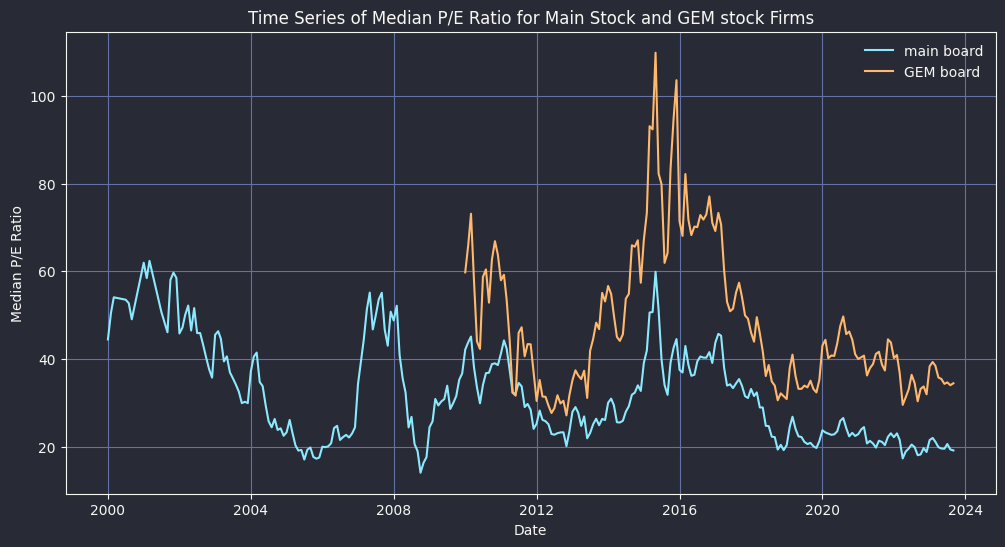

In [14]:
# question 2
# plot two time-series for median P/E ratio by main board and GEM board
# the general idea is first reorder all the stocks chronologically and then calculate their midian PE ratio
main_board_chrono = main_board.sort_values(by=["trading_month", "stock_code"]).reset_index(drop=True)
main_board_chrono_pe_median = main_board_chrono.groupby("trading_month")["monthly_PE_ratio"].median().reset_index(drop=True)
main_board_chrono_pe_median["date"] = main_board_chrono["trading_month"].unique()
GEM_board_chrono = GEM_board.sort_values(by=["trading_month", "stock_code"]).reset_index(drop=True)
GEM_board_chrono_pe_median = GEM_board_chrono.groupby("trading_month")["monthly_PE_ratio"].median().reset_index(drop=True)
GEM_board_chrono_pe_median["date"] = GEM_board_chrono["trading_month"].unique()

# import plotting module
import matplotlib.pyplot as plt
import matplotx
with plt.style.context(matplotx.styles.dracula):
    plt.figure(figsize=(12, 6))
    plt.plot(main_board_chrono_pe_median["date"], main_board_chrono_pe_median[:-1], label="main board")
    plt.plot(GEM_board_chrono_pe_median["date"], GEM_board_chrono_pe_median[:-1], label="GEM board")
    plt.xlabel("Date")
    plt.ylabel("Median P/E Ratio")
    plt.title("Time Series of Median P/E Ratio for Main Stock and GEM stock Firms")
    plt.grid(True)
    plt.legend()
    plt.show()



### Answer to question 2:
Above is the two time-series for median P/E ratio by market type (main board & GEM board).

(i) It is advisable to consider new investments in both main and GEM markets, since their median P/E ratio is relatively low compared to their corresponding previous data, implying their market value might be undervalued. Investment opportunity may be found within these market at Sep. 2023.

(ii) Trend following strategy: If one market is observed to be consistently outperforms the other market, then I can catch the inertia of it and long to market with rising P/E ratio and short the market with decling P/E ratio.

In [11]:
# question 3
data = pd.read_csv("./problem3_data.csv")
data["EndDate"] = pd.to_datetime(data["EndDate"])
# add 2010 data is to derive the total revenue growth rate 

# calculate the annual median values for ROE and the total revennue growth
roe_median = data.groupby("EndDate")["ROEC"].median().reset_index()
# Calculate the total revenue growth rate
data["RevenueGrowth"] = data.groupby("Symbol")["TotalRevenue"].pct_change() * 100
# Calculate the annual median of total revenue growth rate
revenue_median = data.groupby("EndDate")["RevenueGrowth"].median().reset_index()

data = data.drop(data.index[:1]).reset_index(drop=True)
# merge two median factor
data_median = pd.merge(left=roe_median, right=revenue_median, on="EndDate", how="inner")
# illustrate the merged median data

data = data[(data["EndDate"] > "2010-12-31") & 
            (data["EndDate"] <= "2020-12-31")].reset_index(drop=True)
data_median = data_median[(data_median["EndDate"] > "2010-12-31") & 
            (data_median["EndDate"] <= "2020-12-31")].reset_index(drop=True)
data_median

,EndDate,ROEC,RevenueGrowth
0,2011-12-31,0.0912,17.757583
1,2012-12-31,0.0731,6.683501
2,2013-12-31,0.0684,10.706869
3,2014-12-31,0.0701,8.045095
4,2015-12-31,0.0689,4.036511
5,2016-12-31,0.0753,11.164914
6,2017-12-31,0.0819,17.512676
7,2018-12-31,0.0701,10.860522
8,2019-12-31,0.0718,6.755005
9,2020-12-31,0.0781,3.994090


In [12]:
# find the overall number of stocks
# total number of stocks 
total_stock_num = data[data['EndDate'] == '2011-12-31'].shape[0]
# define two list to store the time series proportion
roe_lst = []
rg_lst = []
roe_selected = data[(data["EndDate"] == data_median["EndDate"][0]) &
                    (data["ROEC"] >= data_median["ROEC"][0])]["Symbol"].reset_index(drop=True)
# roe_selected.shape[0] / total_stock_num is approximately to be 0.5
roe_lst.append(0.5)
# rg is short for "revenue growth"
rg_selected = data[(data["EndDate"] == data_median["EndDate"][0]) &
                    (data["RevenueGrowth"] >= data_median["RevenueGrowth"][0])]["Symbol"].reset_index(drop=True)
# rg_selected.shape[0] / total_stock_num is approximately to be 0.5
rg_lst.append(0.5)

for i in range(1, 10):
    roe_selected = data[(data["EndDate"] == data_median["EndDate"][i]) &
                    (data["ROEC"] >= data_median["ROEC"][i]) &
                    (data["Symbol"].isin(roe_selected))]["Symbol"].reset_index(drop=True)
    roe_lst.append(roe_selected.shape[0] / total_stock_num)
    # rg is short for "revenue growth"
    rg_selected = data[(data["EndDate"] == data_median["EndDate"][i]) &
                        (data["RevenueGrowth"] >= data_median["RevenueGrowth"][i]) &
                        (data["Symbol"].isin(rg_selected))]["Symbol"].reset_index(drop=True)
    rg_lst.append(rg_selected.shape[0] / total_stock_num)
print(roe_lst)
print(rg_lst)


[0.5, 0.36140499365213713, 0.3000423190859077, 0.25856961489631825, 0.2090562843842573, 0.17562420651713923, 0.14684722809987305, 0.12568768514600084, 0.10918324164198054, 0.08590774439272111]
[0.5, 0.25687685146000844, 0.15404147270418958, 0.10918324164198054, 0.07744392721117224, 0.05289885738468049, 0.03131612357173085, 0.021159542953872196, 0.013118916631400761, 0.00973338975878121]


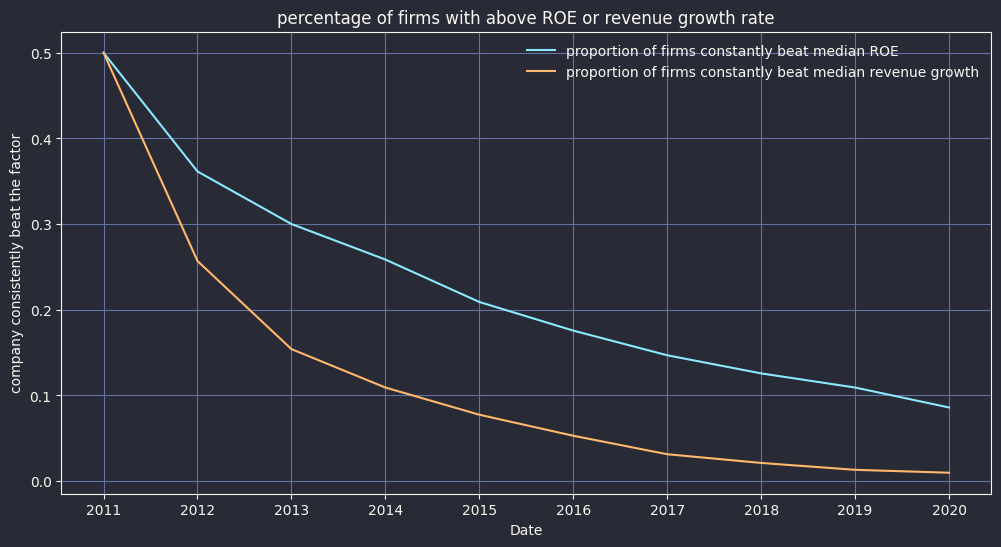

In [13]:
# plot the ratio over time
with plt.style.context(matplotx.styles.dracula):
    plt.figure(figsize=(12, 6))
    plt.plot(range(2011, 2021), roe_lst, label="proportion of firms constantly beat median ROE")
    plt.plot(range(2011, 2021), rg_lst, label="proportion of firms constantly beat median revenue growth")
    plt.xlabel("Date")
    plt.ylabel("company consistently beat the factor")
    plt.title("percentage of firms with above ROE or revenue growth rate")
    plt.xticks(range(2011, 2021))
    plt.grid(True)
    plt.legend()
    plt.show()

Question 3 analysis:
From the above graph, setting the corresponding stocks that beat the median of ROE and revenue growth at the year 2011. As we can see, it is very hard to beat the market constantly over time, even we set the theshrold as "median level". Over ten years, there are less than 10 percent of firms can consistently beat the median factor.